# Snake

In [24]:
from environments import *
import numpy as np
from IPython.display import clear_output
from  tqdm import trange
import matplotlib.pyplot as plt
import os
from models import *
import json
import random
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [25]:
LOAD_FROM_MEMORY = True

## Environment definition

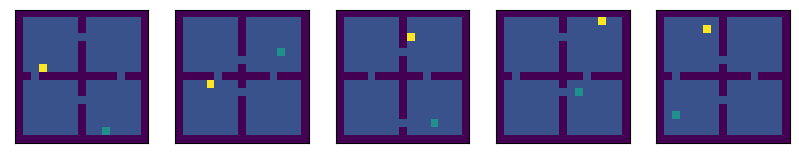

In [26]:
%matplotlib inline
def get_env(n=1000):
    return Walls17x17SnakeEnvironment(n)
env_ = get_env()
GAMMA = .9
ITERATIONS = 10000
EPSILON = 0.02
LAMBDA_VALUE = 0.
LAMBDA_AGENT = 0.
#  ALPHA = 0.1

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## Demo

In [27]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
demo_env = get_env(1000)
def animate(_):
    original_probs = tf.convert_to_tensor([[.25]*4]*demo_env.n_boards)
    mask = get_probabilities_mask(demo_env.boards, original_probs.shape)
    probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]
    actions = tf.random.categorical(tf.math.log(probs),1)
    demo_env.move(actions)
    for board, image in zip(demo_env.boards, images):
        image.set_data(board)
    return images

In [28]:
fig, axs = plt.subplots(1,4, figsize=(10,3))
images = []
for b, ax in zip(demo_env.boards, axs.flatten()):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>

## Model

In [29]:
MODELS_PREFIX = f"py/models/{type(env_).__name__}/{env_.board_size}x{env_.board_size}"
os.makedirs(MODELS_PREFIX, exist_ok=True)

In [30]:
agent, value, avg_rewards = load_models(env_, folder_name=MODELS_PREFIX if LOAD_FROM_MEMORY else None)

## Training

In [31]:
avg_td_error = []

In [32]:
optimizer_value = K.optimizers.Adam(1e-4)
optimizer_agent = K.optimizers.Adam(1e-5)

In [33]:
eligibility_trace_agent = [tf.zeros_like(layer) for layer in agent.trainable_weights]
eligibility_trace_value = [tf.zeros_like(layer) for layer in value.trainable_weights]

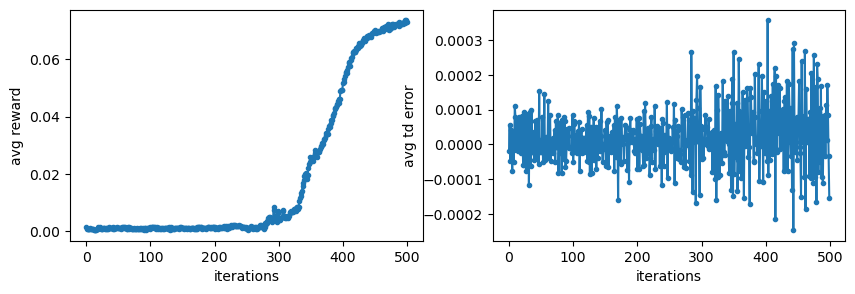

100%|██████████| 50000/50000 [1:53:03<00:00,  7.37it/s]


In [34]:
%matplotlib inline
next_reset = 2
for iteration in trange(ITERATIONS*5):
    state = env_.to_state()
    with tf.GradientTape(persistent=True) as tape:
        original_probs = agent(state)
        mask_with = 0.
        mask = get_probabilities_mask(env_.boards, original_probs.shape, mask_with=mask_with)
        probs = tf.linalg.normalize((original_probs + EPSILON) * mask, ord=1, axis=-1)[0]

        actions = tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)
        rewards = env_.move(actions)
        new_state = tf.constant(env_.to_state())

        value_state = value(state)
        new_value_state = value(new_state)
        td_error = tf.stop_gradient((rewards + GAMMA * new_value_state) - value_state) * -1

        actions_indexes = tf.concat((tf.range(actions.shape[0])[..., None], actions), axis=-1)
        loss_agent = tf.math.log(tf.gather_nd(probs, actions_indexes))[..., None] * tf.stop_gradient(td_error)
        loss_value = tf.stop_gradient(td_error) * value_state

        loss_agent = tf.reduce_mean(loss_agent)
        loss_value = tf.reduce_mean(loss_value)

    avg_td_error.append(tf.reduce_mean(td_error))
    avg_rewards.append(np.mean(rewards == env_.FRUIT_REWARD))

    gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
    gradient_value = tape.gradient(loss_value, value.trainable_weights)

    if LAMBDA_AGENT > 1e-4 or LAMBDA_VALUE > 1e-4:
        eligibility_trace_agent = [GAMMA * LAMBDA_AGENT * layer + gradient for layer, gradient in
                                   zip(eligibility_trace_agent, gradient_agent)]
        eligibility_trace_value = [GAMMA * LAMBDA_VALUE * layer + gradient for layer, gradient in
                                   zip(eligibility_trace_value, gradient_value)]
        optimizer_value.apply_gradients(zip(eligibility_trace_value, value.trainable_weights))
        optimizer_agent.apply_gradients(zip(eligibility_trace_agent, agent.trainable_weights))
    else:
        optimizer_value.apply_gradients(zip(gradient_value, value.trainable_weights))
        optimizer_agent.apply_gradients(zip(gradient_agent, agent.trainable_weights))

    # every N iterations, plot the avg reward of each chunk of 100 iterations, and save the models
    N = 100
    if len(avg_rewards) % N == 0 and len(avg_rewards) > 0:
        # clear output
        clear_output(wait=True)
        # plot
        points_r = np.array(avg_rewards).reshape((-1, N)).mean(axis=-1)
        points_t = np.array(avg_td_error).reshape((-1, N)).mean(axis=-1) * -1
        fig, axs = plt.subplots(1,2, figsize=(10,3))
        axs[0].plot(points_r, marker=".")
        axs[0].set_xlabel("iterations")
        axs[0].set_ylabel("avg reward")
        axs[1].plot(points_t, marker=".")
        axs[1].set_xlabel("iterations")
        axs[1].set_ylabel("avg td error")

        plt.show()
        # save
        with open(f"{MODELS_PREFIX}/training.txt", "w+") as file:
            json.dump(np.array(avg_rewards).tolist(), file)
        agent.save_weights(f"{MODELS_PREFIX}/agent")
        value.save_weights(f"{MODELS_PREFIX}/value")

 ### Random policy reward

In [46]:
random_env = get_env(1000)
random_rewards = []

for _ in trange(1000):
    original_probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    mask = get_probabilities_mask(random_env.boards, original_probs.shape)
    probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards == env_.FRUIT_REWARD))

100%|██████████| 1000/1000 [00:15<00:00, 63.54it/s]


## Training evaluation

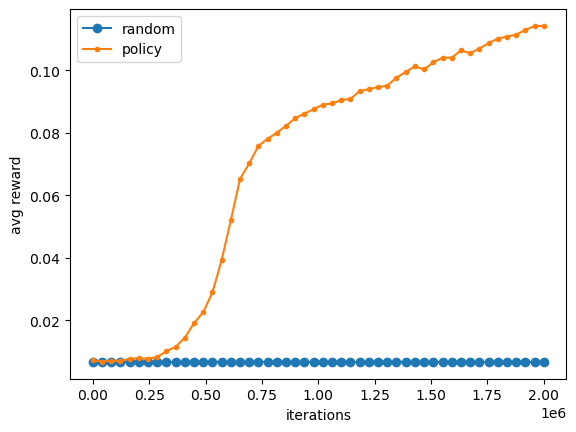

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
CHUNK_SIZE = 200
N = len(avg_rewards)//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
plt.plot(x, np.array(random_rewards[700:]).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])

 ## Test (graphical simulation)

In [35]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [36]:
test_env = get_env(3)

In [37]:
def animate(_):
    original_probs = tf.concat((agent(
        test_env.to_state()
    )[:-1]+ EPSILON, [[.25]*4]), axis=0)

    mask = get_probabilities_mask(test_env.boards, original_probs.shape)
    probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]

    actions = tf.random.categorical(tf.math.log(probs),1)
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [38]:
# first three are policy guided, the fourth is random, to give a comparison
fig, axs = plt.subplots(1,3, figsize=(10,5))
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>